In [1]:
# script to plot standard .las files
# most of the heavy lifting done with lasio and welly (github)


In [1]:
import welly
import lasio
import matplotlib.pyplot as plt
import numpy as np

In [144]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

In [2]:
ls

204-20-2_logs.las       foo.png                 sample_half_meter.jpeg
LICENSE                 plotLAS.ipynb           test.csv
README.md               plot_with_image.ipynb


In [3]:
datafile="204-20-2_logs.las" # want to loop over all *.las files in folder in the future

# depths that you want to plot from 
small, big = 2050, 2700

l = lasio.read(datafile)
well_name = l.well.WELL.value # grab well name from header, needed for plotting later
savefile = well_name + '.png'
savefile=savefile.replace('/','-')


Header section Parameter regexp=~P was not found.


In [4]:
z, gr, neutron, deepR = l['DEPTH'], l['GR'], l['NEUT'], l['RDEP'] # All wells will have this
selfp, microres, density, shalres, sp = l['SP'], l['RMIC'], l['DENS'], l['RSHAL'], l['SP']

# Don't pay attenton to the header error, these are fairly sparce headers (free UK gov .las)

In [5]:
# X = np.random.rand(50)

def get_top_bottom_depth(X, low, high):
    
    idxs = np.where(np.logical_and(X >= low, X <= high))[0]
    return idxs[0], idxs[-1]

itop, ibase = get_top_bottom_depth(z, small, big)

In [139]:
def get_curve_params():
    """
    Because we are removing things from the dictionary and I don't want to re-run
    this cell each time.
    """
    lw = 2.0
    line_styles = {
               'GR': {'lw': lw, 'color':'darkgreen', 'label':'GR', 'units':'API'},
               'SP': {'lw': lw, 'color':'purple', 'label':'SP', 'units': 'mV'},
               'DRes': {'lw': lw, 'color':'black', 'label':'Deep Resitivity', 'xlim':(0.2,200),'units':'ohm.m'}, 
               'NPHI': {'lw': lw, 'color': 'darkblue', 'label':'NPHI', 'units': 'V/V'},
               'RHOB': {'lw': lw, 'color': 'red', 'label':'Bulk Density', 'units':'kg/m^3'},
              }
    return lw, line_styles

# Change only these things 


In [147]:

#These are the only things I want to change
lw, line_styles = get_curve_params()
fontsize = 12
labelpad = 40  # for second x-axis label above the first 
minor_tick_len = 3
nsmooth = 15 # number of samples to smooth
smooth_window = np.ones(nsmooth)/nsmooth
majorLocator = MultipleLocator(50)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(5)

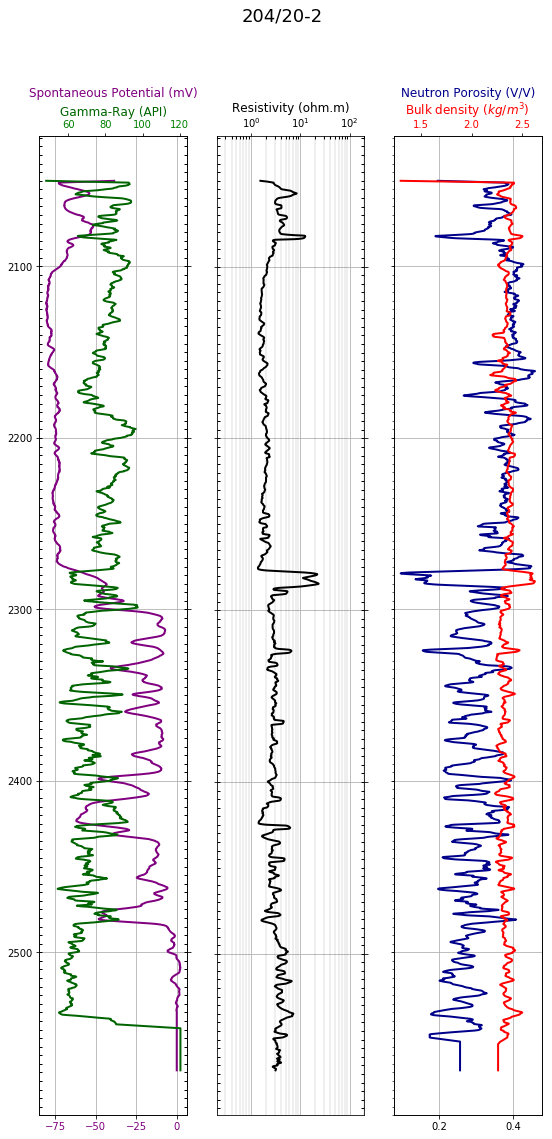

In [148]:
# Lets plot this bad boy
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,18))
# Gamma & SP
units = line_styles['SP'].pop('units')
ax1.plot(np.convolve(smooth_window, sp[itop:ibase], mode='same'), z[itop:ibase],
         '-', **line_styles['SP'])  # Spontaneous Potential
ax1.tick_params(axis='x', labelcolor=line_styles['SP']['color'])
ax1.yaxis.label.set_size(100)
ax1.invert_yaxis()
ax1.grid(True)
ax1.set_xlabel(f'Spontaneous Potential ({units})', size=fontsize, color=line_styles['SP']['color'], 
               labelpad=labelpad)
ax1.xaxis.set_label_position('top')
ax1.yaxis.set_minor_locator(minorLocator)
ax1.yaxis.set_ticks_position('both')
ax1.tick_params(which='minor', length=minor_tick_len, width=1, direction='in')


# Lets do two axis ... one subplot
units = line_styles['GR'].pop('units')
ax4 = ax1.twiny() # same y axis
ax4.plot(np.convolve(smooth_window, gr[itop:ibase], mode='same'),z[itop:ibase],
         **line_styles['GR']) # Gamma Ray
ax4.tick_params(axis='x', labelcolor='Green')
ax4.set_xlabel(f'Gamma-Ray ({units})', size=fontsize, color=line_styles['GR']['color'])
ax4.yaxis.label.set_size(40)
# ax4.grid(True)

# Resistivity
res_xlims = line_styles['DRes'].pop('xlim')
units = line_styles['DRes'].pop('units')

ax2.semilogx(np.convolve(smooth_window, deepR[itop:ibase], mode='same'),
             z[itop:ibase], **line_styles['DRes']) # Deep Induction Resistivity
#ax2.semilogx(shalres[9000:11000], z[9000:11000],'-.', lw=1, color='black', label='RSHAL' ) # Spherically Focussed Log
ax2.axes.yaxis.set_ticklabels([]) # get rid of y axis labels
for xmin in ax2.xaxis.get_minorticklocs():
    ax2.axvline(x=xmin, ls='-', c='k', alpha=0.5, lw=0.25)
ax2.set_xticks([1, 10, 100])
ax2.set_xlim(res_xlims)
ax2.invert_yaxis()
ax2.xaxis.set_label_position('top')
ax2.set_xlabel(f'Resistivity ({units})', size=fontsize)
ax2.yaxis.set_minor_locator(minorLocator)
ax2.tick_params(which='minor', length=4, color='k')
ax2.yaxis.set_minor_locator(minorLocator)
ax2.yaxis.set_ticks_position('both')
ax2.tick_params(which='minor', length=minor_tick_len, width=1, direction='in')
ax2.grid(True)
ax2.yaxis.set_minor_locator(minorLocator)
ax2.yaxis.set_ticks_position('both')
ax2.tick_params(which='minor', length=minor_tick_len, width=1, direction='in')


# Neutron Porosity
units = line_styles['NPHI'].pop('units')
ax3.plot(np.convolve(smooth_window, neutron[itop:ibase], mode='same'),
                     z[itop:ibase], **line_styles['NPHI']) # Neutron Porosity
ax3.axes.yaxis.set_ticklabels([]) # get rid of y axis labels
ax3.set_xlabel(f'Neutron Porosity ({units})', size=fontsize, color='darkblue',            
               labelpad=labelpad)
ax3.xaxis.set_label_position('top')
ax3.invert_yaxis()
ax3.grid(True)

# and Bulk Density
units = line_styles['RHOB'].pop('units')
ax5 = ax3.twiny()
ax5.plot(np.convolve(smooth_window, density[itop:ibase], mode='same'),
         z[itop:ibase], **line_styles['RHOB']) # Bulk Density
ax5.set_xlabel(f'Bulk density (${units}$)', size=fontsize, color='r')
ax5.tick_params(axis='x', labelcolor='red')
ax5.yaxis.set_minor_locator(minorLocator)
ax5.yaxis.set_ticks_position('both')
ax5.tick_params(which='minor', length=minor_tick_len, width=1, direction='in')


## overall 
plt.suptitle(well_name, fontsize=18) # well name title
plt.savefig(savefile, dpi=300) # save out to .png
#plt.savefig('foo3.svg', dpi=300) # save out to .svg
#plt.savefig('foo3.pdf', dpi=300) # save out to .svg

plt.show()

# Then I'm going to see if I can make it look this way using Welly's plot API

In [150]:
from welly import Well

w = Well.from_las(datafile)

Header section Parameter regexp=~P was not found.


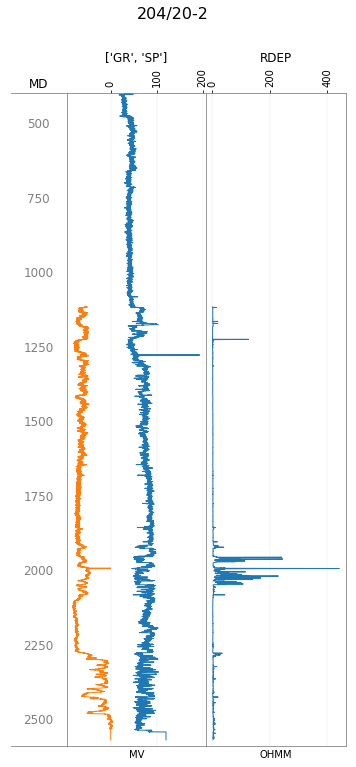

In [151]:
w.plot(tracks=['MD',['GR', 'SP'], 'RDEP'], legend = line_styles)